In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "kaggle"

!mkdir kaggle #create the .kaggle folder in your root directory

!echo '{"username":"thorirhrafn","key":"66bddf37f9b12480c4422871e08090ab"}' > kaggle/kaggle.json #write kaggle API credentials to kaggle.json

!chmod 600 kaggle/kaggle.json  # set permissions

# Get data from Kaggle profile

! kaggle datasets download thorirhrafn/wiringmixed

# Unzip Kaggle data

! unzip wiringmixed.zip

In [ ]:
# Import libraries

import os
import csv
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import pandas as pd
import torch.utils.data
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils

from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

In [ ]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
#Check an images

from IPython.display import Image

Image(filename='wiring_mixed/Train/1_Fail/F211355M0079_31936.jpg')

Num of training data: 2040
label: 0


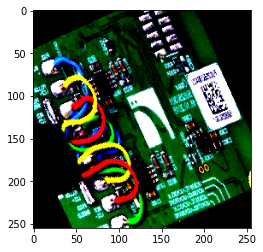

In [ ]:
from torchvision.transforms.transforms import ColorJitter
from torchvision.transforms.functional import crop
from torch.utils.data import WeightedRandomSampler

#def crop_to_wires(image):
#    return crop(image, 0, 400, 600, 400)

train_transform = transforms.Compose([
                  # transforms.ToPILImage(),
                  transforms.Resize([255,255]),
                  transforms.RandomRotation(degrees=25),
                  transforms.RandomHorizontalFlip(p=0.5),
                  transforms.RandomVerticalFlip(p=0.2),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225]) #ImgNet dataset mean & std deviation
                  ])

test_transform = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Resize([255,255]),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225]) #ImgNet dataset mean & std deviation
                  ])

training_dataset = datasets.ImageFolder(root='wiring_mixed/Train', transform=train_transform)
validation_dataset = datasets.ImageFolder(root='wiring_mixed/Validate', transform=test_transform)
test_dataset = datasets.ImageFolder(root='wiring_mixed/Test', transform=test_transform)

print(f'Num of training data: {len(training_dataset)}')
# print(training_dataset[100][1])

tensor_img = training_dataset[400][0]
print(f'label: {training_dataset[400][1]}')
tensor_img = tensor_img.cpu()
plt.imshow(  tensor_img.permute(1, 2, 0)  )


In [ ]:

# create dataloaders for training and testing
SIZE = 16

# create a weighted random sampler to counter the imbalance in the dataset
y_train = training_dataset.targets
class_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
wr_sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

#test_loader = DataLoader(training_dataset, batch_size=16,
#                          shuffle=False, sampler=sampler)


train_dl = torch.utils.data.DataLoader(training_dataset, batch_size=SIZE, shuffle=False, sampler = wr_sampler)
val_dl = torch.utils.data.DataLoader(validation_dataset, batch_size=SIZE, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=SIZE, shuffle=False)

count = 0
num = 5
for data in train_dl:
    X, y = data
    print(y)
    count += 1
    if count > num:
      break

tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0])
tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1])
tensor([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1])
tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1])
tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])


In [ ]:
'''
numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print(len(np.where(target == 0)[0]), len(np.where(target == 1)[0]))

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

y_train = training_dataset.targets
class_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_count
samples_weight = np.array([weight[t] for t in y_train])
# samples_weight = torch.from_numpy(samples_weight)

samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target = torch.from_numpy(target).long()
train_dataset = torch.utils.data.TensorDataset(data, target)

test_loader = DataLoader(training_dataset, batch_size=16,
                          shuffle=False, sampler=sampler)

count = 0
num = 5
for data in test_loader:
    X, y = data
    print(y)
    count += 1
    if count > num:
      break
'''

'\nnumDataPoints = 1000\ndata_dim = 5\nbs = 100\n\n# Create dummy data with class imbalance 9 to 1\ndata = torch.FloatTensor(numDataPoints, data_dim)\ntarget = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),\n                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))\n\nprint(len(np.where(target == 0)[0]), len(np.where(target == 1)[0]))\n\nclass_sample_count = np.array(\n    [len(np.where(target == t)[0]) for t in np.unique(target)])\nweight = 1. / class_sample_count\nsamples_weight = np.array([weight[t] for t in target])\n\ny_train = training_dataset.targets\nclass_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])\n\nweight = 1. / class_count\nsamples_weight = np.array([weight[t] for t in y_train])\n# samples_weight = torch.from_numpy(samples_weight)\n\nsamples_weight = torch.from_numpy(samples_weight)\n# samples_weigth = samples_weight.double()\nsampler = WeightedRandomSampler(samples_weight, len(samples_weight))\n\ntarget = to

In [ ]:
from torchsummary import summary
# Create Convolutional Neural Network Model (CNN)
class WiringCNN(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
        # 3 x 200 x 150
        nn.Conv2d(3, 16, kernel_size=(3,3), stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ) #.cuda()
    self.batch_norm1 = nn.BatchNorm2d(16)   #.cuda()
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=(3,3), stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ) #.cuda()
    self.batch_norm2 = nn.BatchNorm2d(32) #.cuda()
    self.conv3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ) #.cuda()
    self.layer_3 = nn.Flatten() #.cuda()
    self.drop1 = nn.Dropout(p=0.75)
    self.layer_4 = nn.Linear(33280 , 1024) #.cuda()
    self.batch_norm3 = nn.BatchNorm1d(1024) #.cuda()
    self.relu1 = nn.ReLU()  #.cuda()
    self.drop2 = nn.Dropout(p=0.75)
    self.layer_5 = nn.Linear(1024,1)  #.cuda()

    return


  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x = self.conv3(x)
    x = self.layer_3(x) # Flatten
    x = self.drop1(x)
    x = self.layer_4(x)
    x = self.batch_norm3(x)
    x = self.relu1(x)
    x = self.drop2(x)
    x = self.layer_5(x)

    return x     # torch.sigmoid(x) #.log_softmax(x, dim=1)

# model = WiringCNN()
# model = model.to(device)
# print(model)
# summary(model,(3,200,150))

WiringCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_3): Flatten(start_dim=1, end_dim=-1)
  (drop1): Dropout(p=0.75, inplace=False)
  (layer_4): Linear(in_features=33280, out_features=1024, bias=True)
  (batch_norm3): BatchNorm1d(1024

In [ ]:
from torchsummary import summary
# Create Convolutional Neural Network Model (CNN)
class UpdatedWiringCNN(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
        # 3 x 255 x 255
        nn.Conv2d(3, 32, kernel_size=(7,7), stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,64, kernel_size=(5,5), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256,256, kernel_size=(3,3), stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.dense = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.5),
        nn.Linear(57600, 1024),
        nn.BatchNorm1d(1024) ,
        nn.ReLU()
    )

    self.out = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(1024,1)
    )

    return


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.dense(x)
    x = self.out(x)

    return x

model = UpdatedWiringCNN()
model = model.to(device)
print(model)
summary(model,(3,255,255))

UpdatedWiringCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv

In [ ]:
'''
def binary_accuracy(y_pred, y_test):
    y_pred_label = torch.round(torch.sigmoid(y_pred))
    #print(f'y_pred: {y_pred}')
    #print(f'y_pred_label: {y_pred_label}')
    #print(f'y_test: {y_test}')
    sum_correct = (y_pred_label == y_test).sum().float()
    accuracy = sum_correct/y_test.shape[0]
    accuracy = torch.round(accuracy * 100)

    return accuracy
'''

"\ndef binary_accuracy(y_pred, y_test):\n    y_pred_label = torch.round(torch.sigmoid(y_pred))\n    #print(f'y_pred: {y_pred}')\n    #print(f'y_pred_label: {y_pred_label}')\n    #print(f'y_test: {y_test}')\n    sum_correct = (y_pred_label == y_test).sum().float()\n    accuracy = sum_correct/y_test.shape[0]\n    accuracy = torch.round(accuracy * 100)\n    \n    return accuracy\n"

Epoch: 0
----------------
training loss: 0.8045344948768616
training acc: 86.356
----------
Train Targ: [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training loss: 0.3705872893333435
training acc: 95.886
----------
Train Targ: [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 

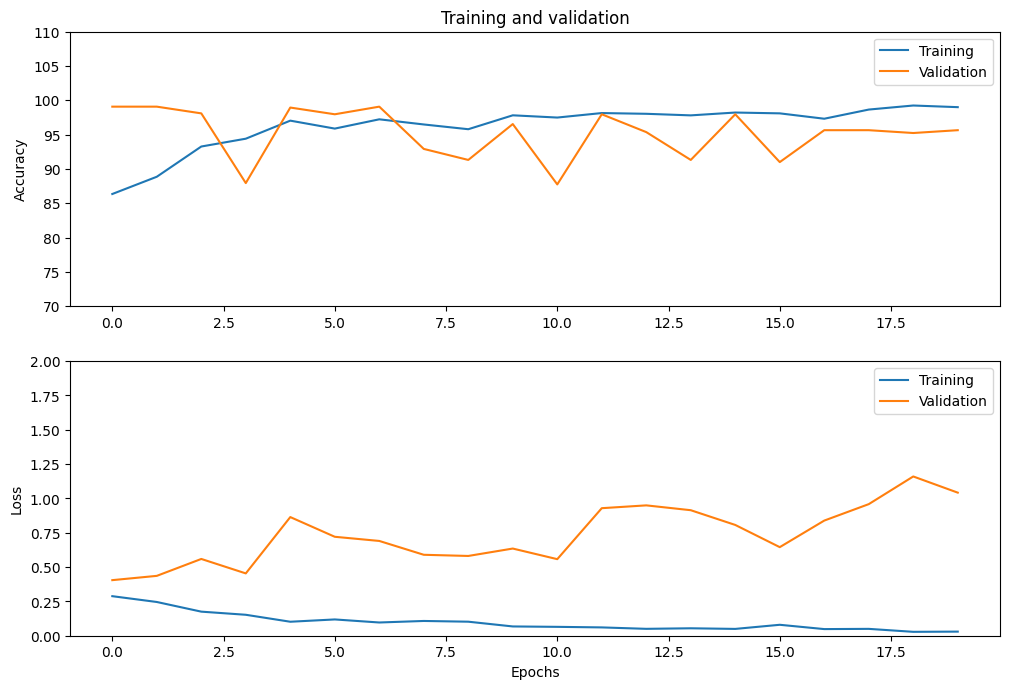

In [ ]:
from google.colab import files

# Train my neural network.

NUM_EPOCHS = 20
t = 0
epochs = []
total_train_loss = []
total_train_acc = []
total_val_loss = []
total_val_acc = []

mod_weight = torch.tensor(1.3)
#print(f'Modified weights: {mod_weight}')

criterion = nn.BCEWithLogitsLoss(pos_weight=mod_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

for epoch in range(NUM_EPOCHS):

  print(f'Epoch: {epoch}')
  print("----------------")
  train_accuracy = 0
  train_total = 0
  train_loss = 0
  val_accuracy = 0
  val_total = 0
  val_loss = 0
  epochs.append(epoch)

  train_pred = []
  train_target = []
  correct = 0
  total = 0
  model.train()

  for data in train_dl:
    X_train, y_train = data
    X_train = X_train.to(device) # .cuda()
    y_train = y_train.to(device)   # .cuda()
    optimizer.zero_grad() # clear gradient information.
    output_train = model(X_train)

    for index, value in enumerate(output_train):
      pred = torch.round(torch.sigmoid(value.squeeze(0).cpu()))
      target = y_train[index].squeeze(0).cpu()
      train_pred.append(int(pred.item()))
      train_target.append(target.item())
      if pred == target:
        correct += 1
      total += 1

    # print(f'output: \n {output}')
    # print(f'label: {y_train}')
    y_train = y_train.unsqueeze(1)
    y_train = y_train.float()
    loss = criterion(output_train, y_train)
    accuracy = 100*correct/total  # binary_accuracy(output_train, y_train)
    loss.backward() # do pack-propagation step
    optimizer.step() # tell optimizer that you finished batch/iteration.
    train_loss += loss.item()
    train_accuracy += accuracy  # .item()
  # save loss and accuracy for this epoch
  total_train_loss.append(train_loss/len(train_dl))
  total_train_acc.append(train_accuracy/len(train_dl))
  print(f'training loss: {loss.data}')
  print(f'training acc: {round(train_accuracy/len(train_dl), 3)}')
  print("----------")
  print(f'Train Targ: {train_target}')
  print(f'Train pred: {train_pred}')
  print("----------")

  y_pred = []
  y_target = []

  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for val_data in val_dl:
      X_val, y_val = val_data
      X_val = X_val.cuda()
      y_val = y_val.cuda()
      output_val = model(X_val)

      for index, value in enumerate(output_val):
        pred = torch.round(torch.sigmoid(value.squeeze(0).cpu()))
        target = y_val[index].squeeze(0).cpu()
        y_pred.append(int(pred.item()))
        y_target.append(target.item())
        if pred == target:
          correct += 1
        total += 1

      y_val = y_val.unsqueeze(1)
      y_val = y_val.float()
      loss = criterion(output_val, y_val)
      accuracy = 100*correct/total  # binary_accuracy(output_val, y_val)
      val_loss += loss.item()
      val_accuracy += accuracy  #.item()
    # save loss and accuracy for this epoch
    total_val_loss.append(val_loss/len(val_dl))
    total_val_acc.append(val_accuracy/len(val_dl))
    print(f'validation loss: {loss.data}')
    print(f'validation acc: {round(val_accuracy/len(val_dl), 3)}')
    print("----------")
    print(f'Val Targ: {y_target}')
    print(f'val pred: {y_pred}')
    print("----------")
    precision = precision_score(y_target, y_pred)
    print(f'validation precision: {precision}')
    recall = recall_score(y_target, y_pred)
    print(f'validation Recall: {recall}')
    print("----------")
    print("*******************************")


plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(epochs, total_train_acc, label="Training Accuracy")
plt.plot(epochs, total_val_acc, label="Validation Accuracy")
plt.title("Training and validation")
plt.ylabel('Accuracy')
plt.ylim(70,110)
plt.legend(["Training", "Validation"])

plt.subplot(2,1,2)
plt.plot(epochs, total_train_loss, label="Training Loss")
plt.plot(epochs, total_val_loss, label="Validation Loss")
plt.ylabel('Loss')
plt.ylim(0,2)
plt.xlabel('Epochs')
plt.legend(["Training", "Validation"])

plt.show()


In [ ]:
pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 42.8 MB/s 


In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

from matplotlib.colors import LinearSegmentedColormap

# image, label = [ x[0] for x in iter(test_dl).next() ]
for data in test_dl:
    image, label = data
    if label[0] == torch.tensor(0):
      image = image[0]
      print(label[0])
      break
image = image.unsqueeze(0)
with torch.no_grad():
  model.eval()
  output = model(image.cuda())
  prediction_score, pred_label = torch.topk(output, 1)
  prediction_score.squeeze().item()
  #label.item()
'''
  integrated_gradients = IntegratedGradients(model)
  #attributions_ig = integrated_gradients.attribute(image.cuda(), target=pred_label, n_steps=200)
  noise_tunnel = NoiseTunnel(integrated_gradients)
  attributions_ig_nt = noise_tunnel.attribute(image.cuda(), nt_samples=10, nt_type='smoothgrad_sq', target=pred_label)


default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

                             np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)
'''
#unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
#unorm(image[0])
#img = torchvision.transforms.ToPILImage()(image[0].to('cpu'))
#plt.imshow(img)

tensor(0)


'\n  integrated_gradients = IntegratedGradients(model)\n  #attributions_ig = integrated_gradients.attribute(image.cuda(), target=pred_label, n_steps=200)\n  noise_tunnel = NoiseTunnel(integrated_gradients)\n  attributions_ig_nt = noise_tunnel.attribute(image.cuda(), nt_samples=10, nt_type=\'smoothgrad_sq\', target=pred_label)\n\n\ndefault_cmap = LinearSegmentedColormap.from_list(\'custom blue\', \n                                                 [(0, \'#ffffff\'),\n                                                  (0.25, \'#000000\'),\n                                                  (1, \'#000000\')], N=256)\n\n                             np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0)),\n                             method=\'heat_map\',\n                             cmap=default_cmap,\n                             show_colorbar=True,\n                             sign=\'positive\',\n                             outlier_perc=1)\n\n_ = viz.visualize_image_attr_multiple(n

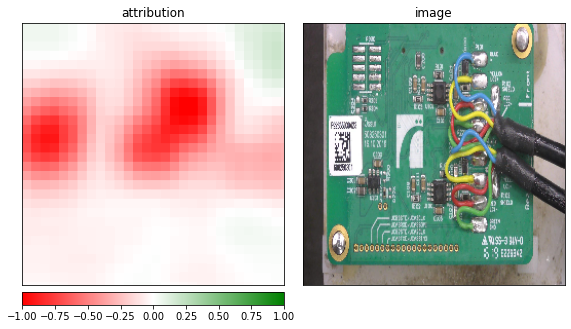

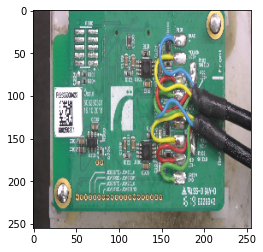

In [ ]:
from PIL import Image
from captum.attr import Occlusion

occlusion = Occlusion(model)

strides = (3, 9, 9)               # smaller = more fine-grained attribution but slower
target=0,                       # Fail index
sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution = occlusion.attribute(image.cuda(),
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)

# Convert the compute attribution tensor into an image-like numpy array
attribution = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
# positive attribution indicates that the presence of the area increases the prediction score
# negative attribution indicates distractor areas whose absence increases the score
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
unorm(image[0])
img = torchvision.transforms.ToPILImage()(image[0].to('cpu'))

_ = viz.visualize_image_attr_multiple(attribution,
                                      np.asarray(img),
                                      vis_types,
                                      vis_signs,
                                      ["attribution", "image"],
                                      show_colorbar = True
                                     )
plt.imshow(img)

Accuracy: 96.89542483660131
----------
Precision: 0.37037037037037035
----------
Recall: 0.8333333333333334
----------
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       600
         1.0       0.37      0.83      0.51        12

    accuracy                           0.97       612
   macro avg       0.68      0.90      0.75       612
weighted avg       0.98      0.97      0.97       612



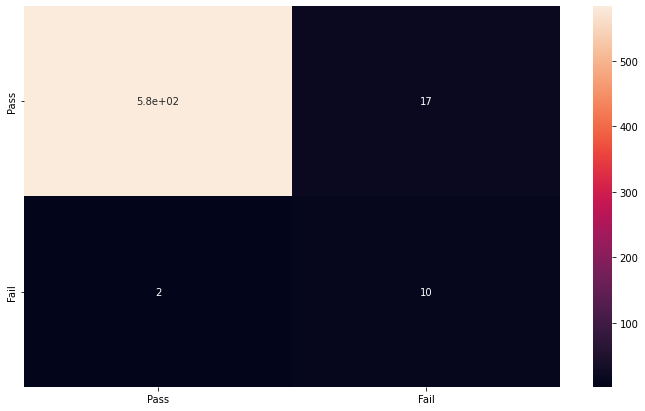

In [ ]:
from sklearn.metrics import classification_report

# Evaluate the trained network.

total = 0
correct = 0
y_pred = []
y_target = []

with torch.no_grad():   # No need for keepnig track of necessary changes to the gradient.
  for data in test_dl:
    X, y = data
    X = X.cuda()
    y = y.cuda()
    output = model(X)

    y = y.unsqueeze(1)
    y = y.float()

    for index, value in enumerate(output):
        pred = torch.round(torch.sigmoid(value.squeeze(0).cpu()))
        target = y[index].squeeze(0).cpu()
        # print(f'Predicion: {pred} , Target: {target}')
        y_pred.append(pred)
        y_target.append(target)
        if pred == target:
          correct += 1
        total += 1

    accuracy = 100*correct/total

  # print(f'Correct: {correct}')
  # print(f'Total: {total}')
  print('Accuracy:', accuracy)
  print("----------")

# y_target = y_target.squeeze(0)
# print(y_target)
# print(y_pred)

precision = precision_score(y_target, y_pred)
print(f'Precision: {precision}')
print("----------")
recall = recall_score(y_target, y_pred)
print(f'Recall: {recall}')
print("----------")
classes = ('Pass', 'Fail')

# Build confusion matrix
cf_matrix = confusion_matrix(y_target, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

print(classification_report(y_target, y_pred))

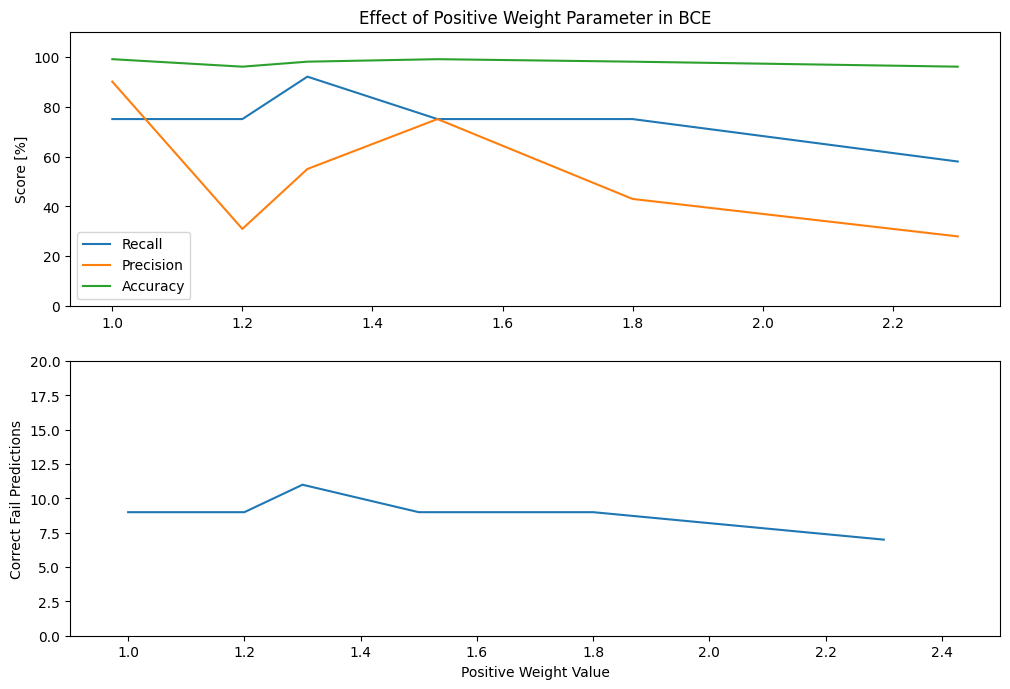

In [ ]:
weight_list = [1.0, 1.2, 1.3, 1.5, 1.8, 2.3]
recall_list = [75, 75, 92, 75, 75, 58]
precision_list = [90, 31, 55, 75, 43, 28]
accuracy_list = [99, 96, 98, 99, 98, 96]
correct_fail = [9, 9, 11, 9, 9, 7]


plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(weight_list, recall_list, label="Recall")
plt.plot(weight_list, precision_list, label="Precision")
plt.plot(weight_list, accuracy_list, label="Accuracy")
plt.title("Effect of Positive Weight Parameter in BCE")
plt.ylabel('Score [%]')
plt.ylim(0,110)
plt.legend(["Recall", "Precision", "Accuracy"])

plt.subplot(2,1,2)
plt.plot(weight_list, correct_fail, label="Correct Fail Predictions")
plt.ylabel('Correct Fail Predictions')
plt.xlim(0.9,2.5)
plt.ylim(0,20)
plt.xlabel('Positive Weight Value')

plt.show()


In [ ]:
recall_list = [75, 75, 92, 75, 75, 58]
precision_list = [90, 31, 55, 75, 43, 28]